In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel("DataCore.xlsx")

In [ ]:
df

In [ ]:
df = df.rename(columns={'INF': 'INFLATION'})
df.drop(['ROE', 'NIM','CUS'], axis=1, inplace=True)

In [ ]:
df

In [ ]:
df.describe(include='all')

In [ ]:
bien_doc_lap = ['DEP','CASH','LGAP','NPL','SIZE', 'CR3','VCSH', 'RRTD','GDP', 'INFLATION']
bien_phu_thuoc = ['ROA']
danh_sach_bien = ['ROA','DEP','CASH','LGAP','NPL','SIZE', 'CR3','VCSH', 'RRTD','GDP', 'INFLATION']

In [ ]:
#phân tích ma trận tự tương quan của các biến độc lập
corr_matrix = df[bien_doc_lap].corr()
corr_matrix

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Bảng kết quả phân tích tự tương quan của các biến độc lập trong mô hình')

In [ ]:
y_bien = 'ROA'
n = len(bien_doc_lap)

# Tạo Figure: n hàng, 3 cột
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(18, n * 5))

if n == 1:
    axes = axes.reshape(1, -1)

for i, col in enumerate(bien_doc_lap):
    # Tính toán các chỉ số
    s_val = df[col].skew()
    max_val = df[col].max()

    # 1. Boxplot dọc (Cột 0) - Hiển thị râu đến Max tuyệt đối
    sns.boxplot(y=df[col], ax=axes[i, 0], color='skyblue', width=0.4, whis=(0, 100))
    axes[i, 0].set_title(f'Boxplot của {col}\n(Max: {max_val:.2f})')
    axes[i, 0].set_ylabel('Giá trị')

    # 2. Histogram thực thụ (Cột 1) - Thể hiện độ lệch
    # element="step" hoặc "bars" với linewidth rõ ràng sẽ tạo cảm giác histogram chuẩn
    sns.histplot(df[col], kde=True, ax=axes[i, 1], color='green',
                 bins='auto',           # Tự động tính số cột tối ưu
                 edgecolor='white',    # Thêm viền trắng giữa các cột cho rõ ràng
                 line_kws={'linewidth': 3}) # Làm đậm đường cong KDE

    axes[i, 1].set_title(f'Histogram & Độ lệch: {s_val:.2f}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Tần suất')
    # Đường Median (Trung vị) để đối chiếu độ lệch
    axes[i, 1].axvline(df[col].median(), color='blue', linestyle='--', label='Median')
    axes[i, 1].legend()

    # 3. Regplot (Cột 2) - Mối quan hệ với ROA
    sns.regplot(data=df, x=col, y=y_bien, ax=axes[i, 2],
                scatter_kws={'alpha':0.4, 's':25},
                line_kws={'color':'red'})
    axes[i, 2].set_title(f'Hồi quy: {col} vs {y_bien}')
    axes[i, 2].set_xlabel(col)
    axes[i, 2].set_ylabel(y_bien)
plt.tight_layout()


In [ ]:
# thực hiện kiểm định đa cộng tuyến
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

def check_vif_final(df, bien_doc_lap):
    # 1. Chuẩn bị dữ liệu
    X = df[bien_doc_lap].dropna()
    X_with_const = add_constant(X)

    # 2. Tính VIF và làm tròn
    vif_data = pd.DataFrame()
    vif_data["Biến độc lập"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                        for i in range(len(X_with_const.columns))]

    # 3. Lọc bỏ 'const', sắp xếp và làm tròn 2 chữ số
    vif_result = vif_data[vif_data["Biến độc lập"] != "const"].copy()
    vif_result["VIF"] = vif_result["VIF"].round(2)
    vif_result = vif_result.sort_values(by="VIF", ascending=False).reset_index(drop=True)

    # 4. Tính trung bình và làm tròn
    vif_mean = round(vif_result["VIF"].mean(), 2)

    # 5. Thêm hàng trung bình
    mean_row = pd.DataFrame([{"Biến độc lập": "--- TRUNG BÌNH ---", "VIF": vif_mean}])
    vif_final = pd.concat([vif_result, mean_row], ignore_index=True)

    return vif_final


vif_table = check_vif_final(df, bien_doc_lap)
print(vif_table)

In [ ]:
# Thực hiện các kiểm định để lựa chọn mô hình hồi quy phù hợp trong các mô hình: Pooled OLS, FEM (Fixed Effects), REM (Random Effects)
## Bước 1: Kiểm định F-test (So sánh Pooled OLS và Fixed Effects - Kiểm định này xem xét liệu có sự khác biệt đặc thù giữa các đơn vị quan sát hay không.)
## Giả thuyết Ho: Mô hình Pooled OLS là phù hợp (không có đặc điểm riêng biệt giữa các đơn vị).
### Nếu p-value < 0.05: Bác bỏ Ho:, chọn mô hình Fixed Effects (FE).
### Nếu p-value > 0.05: Chọn Pooled OLS
from linearmodels import PooledOLS, PanelOLS, RandomEffects
import statsmodels.api as sm

# 1. Chuẩn bị dữ liệu (Giả sử df có cột 'Entity' và 'Year')
df_panel = df.set_index(['BANK', 'YEAR'])
exog = sm.add_constant(df_panel[bien_doc_lap])
endog = df_panel['ROA']

# 2. Chạy các mô hình
mod_pooled = PooledOLS(endog, exog).fit()
mod_fe = PanelOLS(endog, exog, entity_effects=True).fit()
mod_re = RandomEffects(endog, exog).fit()

# 3. In kết quả để so sánh p-value của các kiểm định đính kèm
print(mod_fe) # Xem F-test for individual effects
print(mod_re)

In [ ]:
# Kiểm định Hausman (So sánh Fixed Effects và Random Effects)
## kiểm tra xem sai số đặc thù có tương quan với các biến độc lập hay không
## Giả thuyết Ho: Mô hình Random Effects (RE) là phù hợp.
### Nếu p-value < 0.05: Bác bỏ Ho, chọn mô hình Fixed Effects (FE).
### Nếu p-value > 0.05: Chọn mô hình Random Effects (RE).
import scipy.stats as stats

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b.shape[0]
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B))
    p_val = stats.chi2.sf(chi2, df)
    return chi2, p_val

chi2, p_val = hausman(mod_fe, mod_re)
print(f"Hausman Test: Chi2 = {chi2:.2f}, p-value = {p_val:.4f}")

In [ ]:
# Kiểm định các khuyết tật (Diagnostics): Tự tương quan (Autocorrelation) và Phương sai sai số thay đổi (Heteroskedasticity)
# 1. Kiểm định Phương sai sai số thay đổi (Heteroskedasticity)
import statsmodels.stats.api as sms

# Giả sử 'mod_fe' là kết quả từ PanelOLS(endog, exog, entity_effects=True).fit()
def check_heteroskedasticity(model):
    # Lấy phần dư
    residuals = model.resids

    # Kiểm định Breusch-Pagan
    # Cần dùng ma trận biến độc lập từ mô hình
    exog = model.model.exog.values2d
    names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    test = sms.het_breuschpagan(residuals, exog)

    print("--- Kiểm định Phương sai sai số thay đổi (Breusch-Pagan) ---")
    print(dict(zip(names, test)))

    if test[1] < 0.05:
        print("Kết quả: Có hiện tượng Phương sai sai số thay đổi (p < 0.05)")
    else:
        print("Kết quả: Không có hiện tượng Phương sai sai số thay đổi")

check_heteroskedasticity(mod_fe)

In [ ]:
# 2. Kiểm định Tự tương quan (Autocorrelation)
from linearmodels.panel import PanelOLS

def check_autocorrelation(df, y_name, x_names):
    # Kiểm định Wooldridge cho dữ liệu bảng
    # Ý tưởng: Hồi quy phần dư bậc 1
    # Thư viện linearmodels không có sẵn lệnh Wooldridge trực tiếp như Stata
    # nhưng ta có thể quan sát qua kiểm định Durbin-Watson trên phần dư

    from statsmodels.stats.stattools import durbin_watson

    # Lấy phần dư từ mô hình FE
    residuals = mod_fe.resids
    dw_stat = durbin_watson(residuals)

    print(f"\n--- Kiểm định Durbin-Watson cho Tự tương quan ---")
    print(f"Giá trị DW: {dw_stat:.4f}")
    print("Ghi chú: DW gần 2 là không có tự tương quan. Gần 0 là tự tương quan dương, gần 4 là âm.")

check_autocorrelation(df, 'ROA', bien_doc_lap)

In [ ]:
## Qua các kết quả kiểm định nêu trên cho thấy mô hình hồi quy theo phương pháp bình phương bé nhất Pooled OLS, FEM là không phù hợp, vì mô hình vi phạm các giả định hồi quy như tự tương quan và phương sai thay đổi. Khi đó sẽ dẫn tới kết quả hồi quy không còn chính xác. Để khắc phục những vi phạm trên bài viết tiếp tục dùng phương pháp bình phương bé nhất tổng quát (GLS) để khắc phục các hiện tượng trên.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. Định nghĩa công thức
formula = "ROA ~ DEP + CASH + LGAP + NPL + SIZE + CR3 + VCSH + RRTD + GDP + INFLATION"

# 2. Khởi tạo mô hình GEE
model = smf.gee(formula=formula,
                groups=df["BANK"],
                data=df,
                cov_struct=sm.cov_struct.Exchangeable(),
                family=sm.families.Gaussian())

# 3. Fit mô hình với cov_type='naive'
# 'naive' sẽ tính toán sai số chuẩn dựa trên giả định mô hình (giống xtgls mặc định)
# giúp P-value của INFLATION và SIZE thu nhỏ lại sát với Stata.
results = model.fit(cov_type='naive')

# 4. Hiển thị bảng kết quả
print("--- KẾT QUẢ MÔ HÌNH GLS (GEE) ---")
print(results.summary())

# 5. Kiểm định Wald tổng thể
print("\n--- KIỂM ĐỊNH WALD TỔNG THỂ ---")
print(results.wald_test_terms())

In [ ]:
# 1. Lấy giá trị dự báo từ mô hình
y_pred = results.predict(df)

# 2. Lấy giá trị thực tế (ROA)
y_actual = df['ROA']

# 3. Tính hệ số tương quan bình phương (tương đương R-squared)
correlation_matrix = np.corrcoef(y_actual, y_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(f"Hệ số xác định R-squared của mô hình là: {r_squared:.4f}")
print(f"Mô hình giải thích được: {r_squared*100:.2f}% sự biến động của ROA")

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 1. Huấn luyện mô hình RF
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(df[bien_doc_lap], df['ROA'])

# 2. Lấy tầm quan trọng của biến
importances = pd.Series(rf.feature_importances_, index=bien_doc_lap).sort_values(ascending=False)
print("Tầm quan trọng của các biến theo Random Forest:")
print(importances)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 1. Huấn luyện RF
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(df[bien_doc_lap], df['ROA'])

# 2. Vẽ biểu đồ Feature Importance
importances = pd.Series(rf.feature_importances_, index=bien_doc_lap).sort_values()
importances.plot(kind='barh', color='skyblue')
plt.title("Tầm quan trọng của các biến (Random Forest)")
plt.show()

In [ ]:
# 1. Lấy dự báo từ GLS đã chạy
df['pred_gls'] = results.predict(df)

# 2. Tính sai số (Residuals)
df['residuals'] = df['ROA'] - df['pred_gls']

# 3. Dùng Random Forest học trên sai số
from sklearn.ensemble import RandomForestRegressor
rf_res = RandomForestRegressor(n_estimators=100, random_state=42)
rf_res.fit(df[bien_doc_lap], df['residuals'])

# 4. Dự báo Hybrid
pred_residual = rf_res.predict(df[bien_doc_lap])
df['pred_hybrid'] = df['pred_gls'] + pred_residual

# 5. Kiểm tra R-squared mới
from sklearn.metrics import r2_score
print(f"R-squared Hybrid: {r2_score(df['ROA'], df['pred_hybrid']):.4f}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================================
# PHẦN 1: CHUẨN BỊ DỮ LIỆU
# ==========================================================

# 1. Danh sách các biến độc lập (phải khớp với mô hình GLS bạn đã chạy)
features = ['DEP', 'CASH', 'LGAP', 'NPL', 'SIZE', 'CR3', 'VCSH', 'RRTD', 'GDP', 'INFLATION']

# 2. Lấy dự báo từ mô hình GLS (GEE) đã chạy ở bước trước
# (Biến 'results' là kết quả từ lệnh model.fit(cov_type='naive') của bạn)
df['GLS_Pred'] = results.predict(df)

# 3. Tính sai số (Residuals) mà GLS chưa giải thích được
df['GLS_Residuals'] = df['ROA'] - df['GLS_Pred']

# ==========================================================
# PHẦN 2: CHẠY RANDOM FOREST TRÊN SAI SỐ (RESIDUAL LEARNING)
# ==========================================================

# Khởi tạo mô hình Random Forest
# n_estimators=100: Số lượng cây
# random_state=42: Để kết quả cố định mỗi lần chạy
rf_residual_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# Huấn luyện RF: Đầu vào là X, Mục tiêu là SAI SỐ (không phải ROA)
rf_residual_model.fit(df[features], df['GLS_Residuals'])

# Dự báo phần sai số bù trừ
df['RF_Residual_Pred'] = rf_residual_model.predict(df[features])

# ==========================================================
# PHẦN 3: TỔNG HỢP KẾT QUẢ (HYBRID MODEL)
# ==========================================================

# Công thức: Kết quả cuối = Phần tuyến tính (GLS) + Phần phi tuyến (RF)
df['Hybrid_Pred'] = df['GLS_Pred'] + df['RF_Residual_Pred']

# ==========================================================
# PHẦN 4: SO SÁNH HIỆU QUẢ
# ==========================================================

def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"RMSE (Sai số chuẩn): {rmse:.5f}")
    print(f"MAE (Sai số tuyệt đối): {mae:.5f}")
    print(f"R-squared (Độ giải thích): {r2:.4f} ({r2*100:.2f}%)")
    print("-" * 30)

print("\n=== KẾT QUẢ SO SÁNH HIỆU QUẢ DỰ BÁO ===")
calculate_metrics(df['ROA'], df['GLS_Pred'], "Mô hình GLS Gốc")
calculate_metrics(df['ROA'], df['Hybrid_Pred'], "Mô hình Hybrid (GLS + RF)")

# ==========================================================
# PHẦN 5: VẼ BIỂU ĐỒ TRỰC QUAN HÓA
# ==========================================================

# Vẽ 50 quan sát đầu tiên để dễ nhìn
plt.figure(figsize=(14, 6))
plt.plot(df['ROA'].values[:50], label='Thực tế', color='black', linewidth=2)
plt.plot(df['GLS_Pred'].values[:50], label='GLS Dự báo', color='red', linestyle='--')
plt.plot(df['Hybrid_Pred'].values[:50], label='Hybrid (GLS+RF)', color='green', linewidth=2)

plt.title('So sánh hiệu quả dự báo: GLS vs Hybrid Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [2]:
df = pd.read_excel("DataCore.xlsx")

In [3]:
df

,YEAR,BANK,CUS,ROA,ROE,NIM,DEP,CASH,LGAP,NPL,SIZE,CR3,VCSH,RRTD,GDP,INF
0,2018,ABB,ABB2018,0.008194,0.110093,0.032627,0.761632,0.139490,-0.190148,0.023422,18.284294,0.437586,0.074426,0.006374,0.070758,0.035394
1,2009,ABB,ABB2009,0.015578,0.073807,0.043999,0.742687,0.462718,-0.198323,0.024272,16.811548,0.443493,0.211059,0.007698,0.053979,0.070546
2,2017,ABB,ABB2017,0.006161,0.081738,0.037870,0.780668,0.197173,-0.222004,0.027180,18.189219,0.452310,0.075381,0.011413,0.068122,0.035203
3,2010,ABB,ABB2010,0.015376,0.108547,0.047665,0.788100,0.298168,-0.242703,0.013691,17.289552,0.402135,0.141657,0.005776,0.064232,0.088616
4,2011,ABB,ABB2011,0.007719,0.065501,0.065404,0.747739,0.232049,-0.243431,0.019986,17.498845,0.383013,0.117843,0.029036,0.062403,0.186755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2013,VPB,VPB2013,0.009088,0.131702,0.059327,0.732269,0.135112,-0.311674,0.028029,18.533730,0.414936,0.064464,0.023214,0.054219,0.065923
317,2012,VPB,VPB2012,0.006937,0.095899,0.049344,0.701148,0.311961,-0.314903,0.023484,18.345370,0.418736,0.068496,0.012231,0.052474,0.090942
318,2017,VTB,VTB2017,0.006710,0.078832,0.023821,0.878382,0.135369,-0.146414,0.014735,17.482040,0.452310,0.081758,0.001782,0.068122,0.035203
319,2018,VTB,VTB2018,0.006909,0.071444,0.027318,0.865519,0.181519,-0.164647,0.013055,17.657171,0.437586,0.084073,0.002491,0.070758,0.035394


In [4]:
df = df.rename(columns={'INF': 'INFLATION'})
df.drop(['ROE', 'NIM','CUS'], axis=1, inplace=True)

In [5]:
df

,YEAR,BANK,ROA,DEP,CASH,LGAP,NPL,SIZE,CR3,VCSH,RRTD,GDP,INFLATION
0,2018,ABB,0.008194,0.761632,0.139490,-0.190148,0.023422,18.284294,0.437586,0.074426,0.006374,0.070758,0.035394
1,2009,ABB,0.015578,0.742687,0.462718,-0.198323,0.024272,16.811548,0.443493,0.211059,0.007698,0.053979,0.070546
2,2017,ABB,0.006161,0.780668,0.197173,-0.222004,0.027180,18.189219,0.452310,0.075381,0.011413,0.068122,0.035203
3,2010,ABB,0.015376,0.788100,0.298168,-0.242703,0.013691,17.289552,0.402135,0.141657,0.005776,0.064232,0.088616
4,2011,ABB,0.007719,0.747739,0.232049,-0.243431,0.019986,17.498845,0.383013,0.117843,0.029036,0.062403,0.186755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,2013,VPB,0.009088,0.732269,0.135112,-0.311674,0.028029,18.533730,0.414936,0.064464,0.023214,0.054219,0.065923
317,2012,VPB,0.006937,0.701148,0.311961,-0.314903,0.023484,18.345370,0.418736,0.068496,0.012231,0.052474,0.090942
318,2017,VTB,0.006710,0.878382,0.135369,-0.146414,0.014735,17.482040,0.452310,0.081758,0.001782,0.068122,0.035203
319,2018,VTB,0.006909,0.865519,0.181519,-0.164647,0.013055,17.657171,0.437586,0.084073,0.002491,0.070758,0.035394


In [6]:
df.describe(include='all')

,YEAR,BANK,ROA,DEP,CASH,LGAP,NPL,SIZE,CR3,VCSH,RRTD,GDP,INFLATION
count,321.000000,321,321.000000,321.000000,321.000000,321.000000,3.210000e+02,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
unique,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,ABB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2013.074766,NaN,0.009021,0.750049,0.220640,-0.206748,2.231160e-02,18.003507,0.433995,0.105141,0.010970,0.061104,0.079406
std,3.133591,NaN,0.008355,0.080868,0.126600,0.122962,1.252841e-02,1.232005,0.032109,0.051797,0.009056,0.005912,0.063837
min,2008.000000,NaN,-0.059929,0.429914,0.047361,-0.698198,5.802364e-08,14.497839,0.383013,0.033521,-0.013367,0.052474,0.008786
25%,2010.000000,NaN,0.004248,0.694157,0.132856,-0.283034,1.400164e-02,17.043560,0.414936,0.071142,0.005068,0.054219,0.035203
50%,2013.000000,NaN,0.007743,0.757334,0.188523,-0.214794,2.087028e-02,18.056905,0.437586,0.089842,0.008486,0.062108,0.065923
75%,2016.000000,NaN,0.013239,0.812826,0.297587,-0.137525,2.759999e-02,18.921398,0.447359,0.127655,0.015015,0.066793,0.090942


In [7]:
bien_doc_lap = ['DEP','CASH','LGAP','NPL','SIZE', 'CR3','VCSH', 'RRTD','GDP', 'INFLATION']
bien_phu_thuoc = ['ROA']
danh_sach_bien = ['ROA','DEP','CASH','LGAP','NPL','SIZE', 'CR3','VCSH', 'RRTD','GDP', 'INFLATION']

In [8]:
#phân tích ma trận tự tương quan của các biến độc lập
corr_matrix = df[bien_doc_lap].corr()
corr_matrix

,DEP,CASH,LGAP,NPL,SIZE,CR3,VCSH,RRTD,GDP,INFLATION
DEP,1.000000,-0.186539,-0.355814,-0.098082,0.097023,0.242743,-0.348368,-0.082261,0.281790,-0.262631
CASH,-0.186539,1.000000,-0.315253,-0.069681,-0.285094,-0.033886,0.200345,-0.206238,-0.276921,0.386699
LGAP,-0.355814,-0.315253,1.000000,-0.055362,0.073569,0.011658,0.175071,0.065349,0.027177,0.016706
NPL,-0.098082,-0.069681,-0.055362,1.000000,-0.062203,-0.143919,0.097168,0.117686,-0.272114,-0.074901
SIZE,0.097023,-0.285094,0.073569,-0.062203,1.000000,-0.096853,-0.748807,0.160987,0.302338,-0.350440
CR3,0.242743,-0.033886,0.011658,-0.143919,-0.096853,1.000000,0.062530,0.018306,-0.018331,0.154719
VCSH,-0.348368,0.200345,0.175071,0.097168,-0.748807,0.062530,1.000000,0.042370,-0.295563,0.290298
RRTD,-0.082261,-0.206238,0.065349,0.117686,0.160987,0.018306,0.042370,1.000000,0.060827,-0.136658
GDP,0.281790,-0.276921,0.027177,-0.272114,0.302338,-0.018331,-0.295563,0.060827,1.000000,-0.371005
INFLATION,-0.262631,0.386699,0.016706,-0.074901,-0.350440,0.154719,0.290298,-0.136658,-0.371005,1.000000


Text(0.5, 1.0, 'Bảng kết quả phân tích tự tương quan của các biến độc lập trong mô hình')

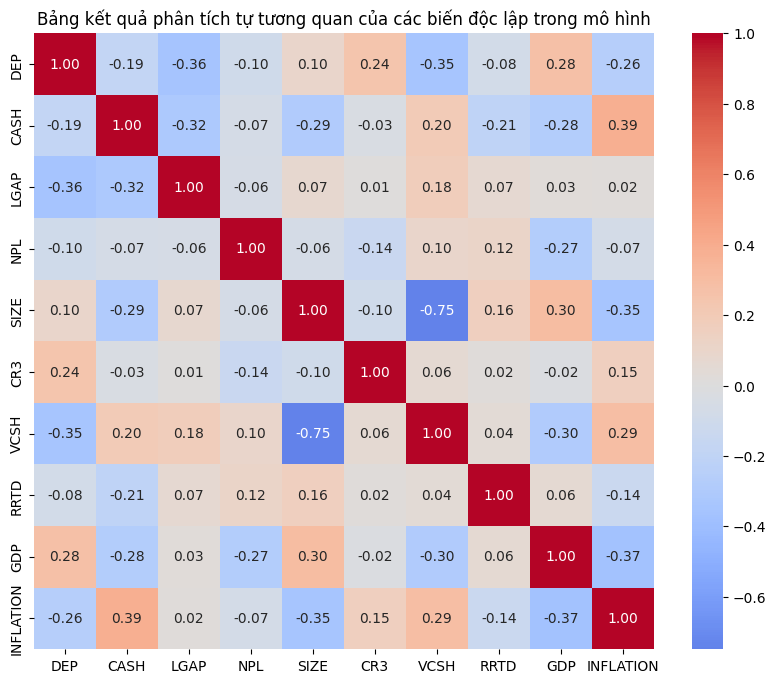

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Bảng kết quả phân tích tự tương quan của các biến độc lập trong mô hình')

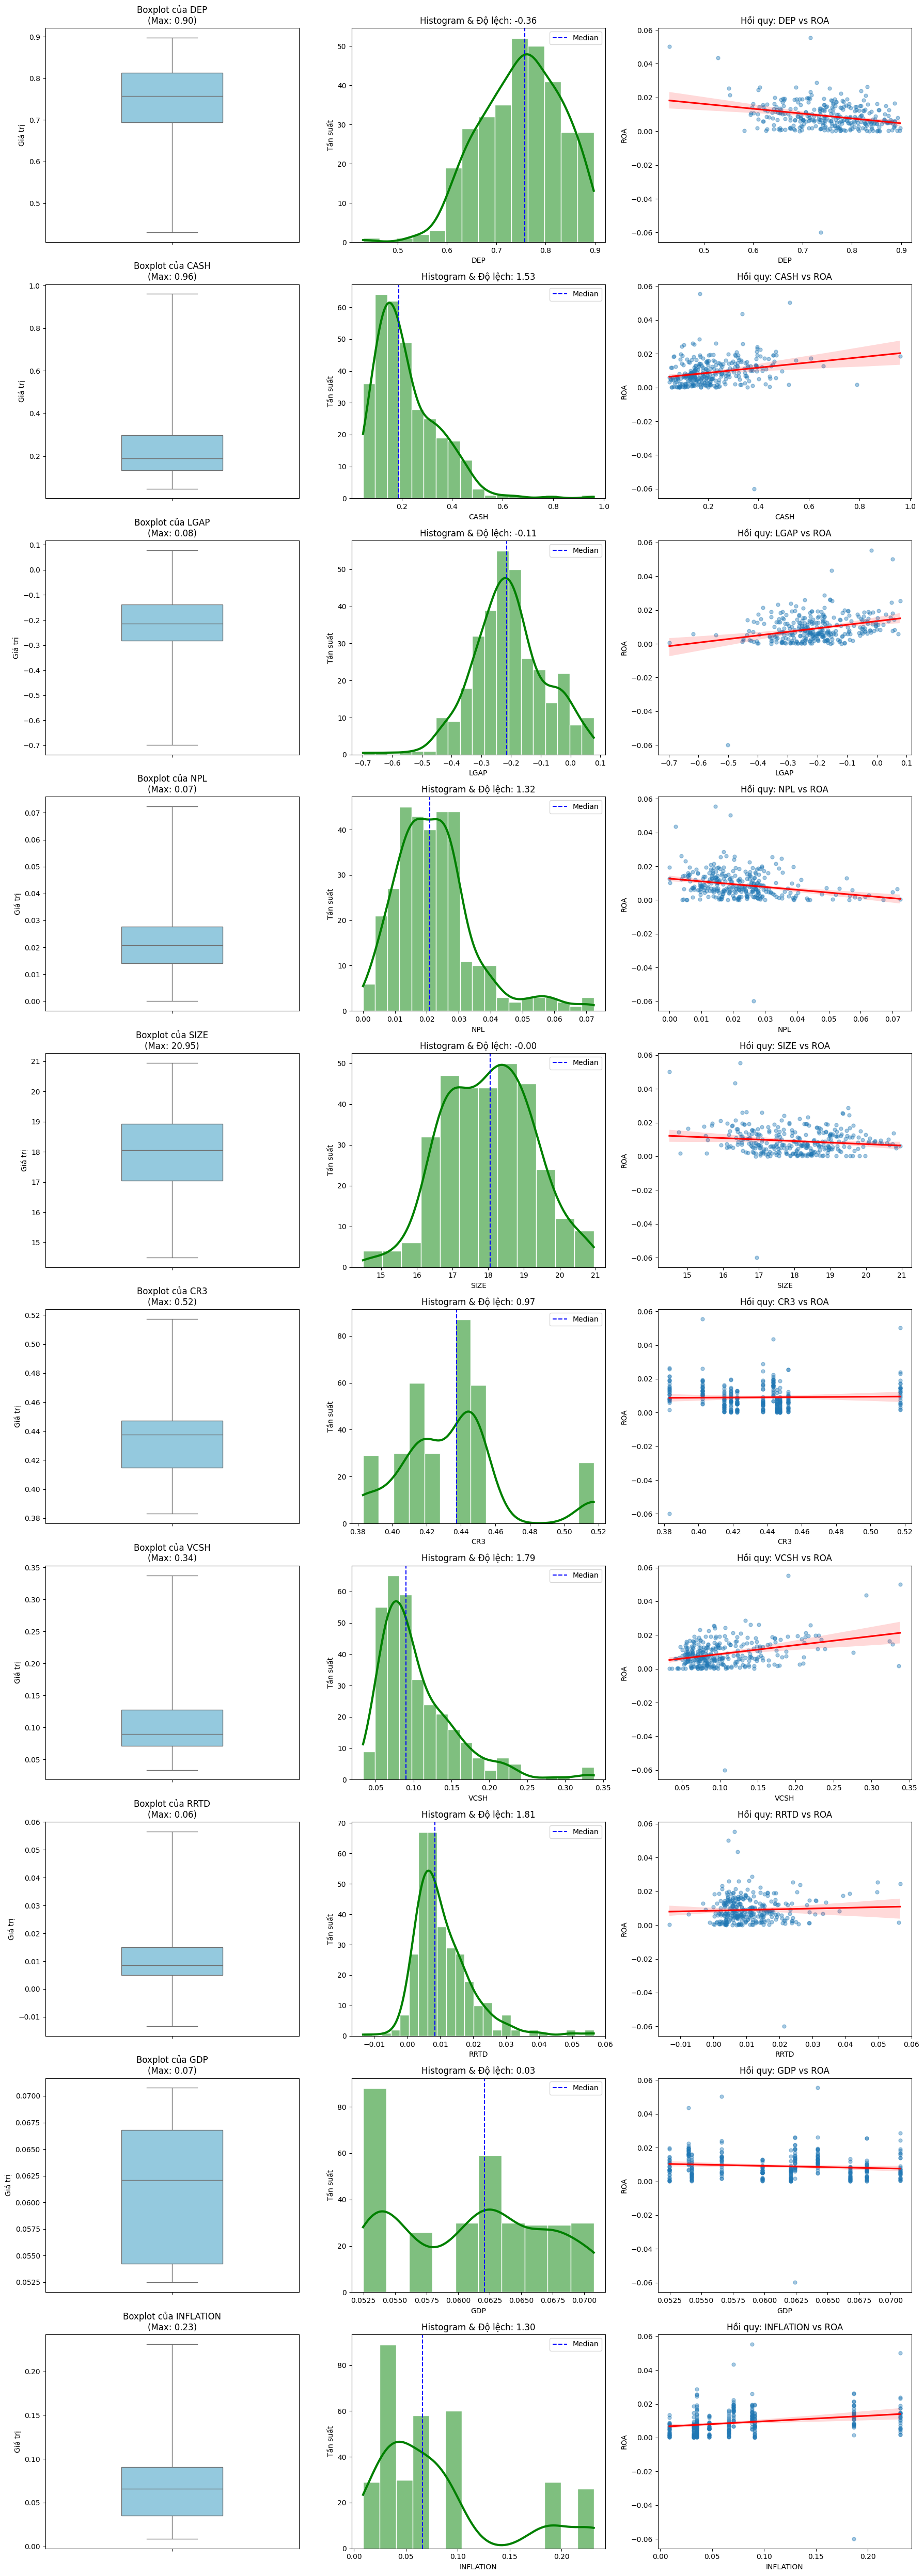

In [10]:
y_bien = 'ROA'
n = len(bien_doc_lap)

# Tạo Figure: n hàng, 3 cột
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(18, n * 5))

if n == 1:
    axes = axes.reshape(1, -1)

for i, col in enumerate(bien_doc_lap):
    # Tính toán các chỉ số
    s_val = df[col].skew()
    max_val = df[col].max()

    # 1. Boxplot dọc (Cột 0) - Hiển thị râu đến Max tuyệt đối
    sns.boxplot(y=df[col], ax=axes[i, 0], color='skyblue', width=0.4, whis=(0, 100))
    axes[i, 0].set_title(f'Boxplot của {col}\n(Max: {max_val:.2f})')
    axes[i, 0].set_ylabel('Giá trị')

    # 2. Histogram thực thụ (Cột 1) - Thể hiện độ lệch
    # element="step" hoặc "bars" với linewidth rõ ràng sẽ tạo cảm giác histogram chuẩn
    sns.histplot(df[col], kde=True, ax=axes[i, 1], color='green',
                 bins='auto',           # Tự động tính số cột tối ưu
                 edgecolor='white',    # Thêm viền trắng giữa các cột cho rõ ràng
                 line_kws={'linewidth': 3}) # Làm đậm đường cong KDE

    axes[i, 1].set_title(f'Histogram & Độ lệch: {s_val:.2f}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Tần suất')
    # Đường Median (Trung vị) để đối chiếu độ lệch
    axes[i, 1].axvline(df[col].median(), color='blue', linestyle='--', label='Median')
    axes[i, 1].legend()

    # 3. Regplot (Cột 2) - Mối quan hệ với ROA
    sns.regplot(data=df, x=col, y=y_bien, ax=axes[i, 2],
                scatter_kws={'alpha':0.4, 's':25},
                line_kws={'color':'red'})
    axes[i, 2].set_title(f'Hồi quy: {col} vs {y_bien}')
    axes[i, 2].set_xlabel(col)
    axes[i, 2].set_ylabel(y_bien)
plt.tight_layout()


In [11]:
# thực hiện kiểm định đa cộng tuyến
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

def check_vif_final(df, bien_doc_lap):
    # 1. Chuẩn bị dữ liệu
    X = df[bien_doc_lap].dropna()
    X_with_const = add_constant(X)

    # 2. Tính VIF và làm tròn
    vif_data = pd.DataFrame()
    vif_data["Biến độc lập"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i)
                        for i in range(len(X_with_const.columns))]

    # 3. Lọc bỏ 'const', sắp xếp và làm tròn 2 chữ số
    vif_result = vif_data[vif_data["Biến độc lập"] != "const"].copy()
    vif_result["VIF"] = vif_result["VIF"].round(2)
    vif_result = vif_result.sort_values(by="VIF", ascending=False).reset_index(drop=True)

    # 4. Tính trung bình và làm tròn
    vif_mean = round(vif_result["VIF"].mean(), 2)

    # 5. Thêm hàng trung bình
    mean_row = pd.DataFrame([{"Biến độc lập": "--- TRUNG BÌNH ---", "VIF": vif_mean}])
    vif_final = pd.concat([vif_result, mean_row], ignore_index=True)

    return vif_final


vif_table = check_vif_final(df, bien_doc_lap)
print(vif_table)

          Biến độc lập   VIF
0                 VCSH  3.12
1                 SIZE  3.01
2                  DEP  1.72
3                 CASH  1.55
4                 LGAP  1.52
5            INFLATION  1.50
6                  GDP  1.42
7                  NPL  1.19
8                  CR3  1.18
9                 RRTD  1.16
10  --- TRUNG BÌNH ---  1.74


In [12]:
# Thực hiện các kiểm định để lựa chọn mô hình hồi quy phù hợp trong các mô hình: Pooled OLS, FEM (Fixed Effects), REM (Random Effects)
## Bước 1: Kiểm định F-test (So sánh Pooled OLS và Fixed Effects - Kiểm định này xem xét liệu có sự khác biệt đặc thù giữa các đơn vị quan sát hay không.)
## Giả thuyết Ho: Mô hình Pooled OLS là phù hợp (không có đặc điểm riêng biệt giữa các đơn vị).
### Nếu p-value < 0.05: Bác bỏ Ho:, chọn mô hình Fixed Effects (FE).
### Nếu p-value > 0.05: Chọn Pooled OLS
from linearmodels import PooledOLS, PanelOLS, RandomEffects
import statsmodels.api as sm

# 1. Chuẩn bị dữ liệu (Giả sử df có cột 'Entity' và 'Year')
df_panel = df.set_index(['BANK', 'YEAR'])
exog = sm.add_constant(df_panel[bien_doc_lap])
endog = df_panel['ROA']

# 2. Chạy các mô hình
mod_pooled = PooledOLS(endog, exog).fit()
mod_fe = PanelOLS(endog, exog, entity_effects=True).fit()
mod_re = RandomEffects(endog, exog).fit()

# 3. In kết quả để so sánh p-value của các kiểm định đính kèm
print(mod_fe) # Xem F-test for individual effects
print(mod_re)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    ROA   R-squared:                        0.3837
Estimator:                   PanelOLS   R-squared (Between):             -0.4588
No. Observations:                 321   R-squared (Within):               0.3837
Date:                Sat, Jan 31 2026   R-squared (Overall):              0.2262
Time:                        10:13:58   Log-likelihood                    1191.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      17.430
Entities:                          31   P-value                           0.0000
Avg Obs:                       10.355   Distribution:                  F(10,280)
Min Obs:                       3.0000                                           
Max Obs:                       11.000   F-statistic (robust):             17.430
                            

In [13]:
# Kiểm định Hausman (So sánh Fixed Effects và Random Effects)
## kiểm tra xem sai số đặc thù có tương quan với các biến độc lập hay không
## Giả thuyết Ho: Mô hình Random Effects (RE) là phù hợp.
### Nếu p-value < 0.05: Bác bỏ Ho, chọn mô hình Fixed Effects (FE).
### Nếu p-value > 0.05: Chọn mô hình Random Effects (RE).
import scipy.stats as stats

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b.shape[0]
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B))
    p_val = stats.chi2.sf(chi2, df)
    return chi2, p_val

chi2, p_val = hausman(mod_fe, mod_re)
print(f"Hausman Test: Chi2 = {chi2:.2f}, p-value = {p_val:.4f}")

Hausman Test: Chi2 = 63.07, p-value = 0.0000


In [14]:
# Kiểm định các khuyết tật (Diagnostics): Tự tương quan (Autocorrelation) và Phương sai sai số thay đổi (Heteroskedasticity)
# 1. Kiểm định Phương sai sai số thay đổi (Heteroskedasticity)
import statsmodels.stats.api as sms

# Giả sử 'mod_fe' là kết quả từ PanelOLS(endog, exog, entity_effects=True).fit()
def check_heteroskedasticity(model):
    # Lấy phần dư
    residuals = model.resids

    # Kiểm định Breusch-Pagan
    # Cần dùng ma trận biến độc lập từ mô hình
    exog = model.model.exog.values2d
    names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
    test = sms.het_breuschpagan(residuals, exog)

    print("--- Kiểm định Phương sai sai số thay đổi (Breusch-Pagan) ---")
    print(dict(zip(names, test)))

    if test[1] < 0.05:
        print("Kết quả: Có hiện tượng Phương sai sai số thay đổi (p < 0.05)")
    else:
        print("Kết quả: Không có hiện tượng Phương sai sai số thay đổi")

check_heteroskedasticity(mod_fe)

--- Kiểm định Phương sai sai số thay đổi (Breusch-Pagan) ---
{'Lagrange multiplier statistic': np.float64(19.270688709250063), 'p-value': np.float64(0.03695621243816782), 'f-value': np.float64(1.9798916698918212), 'f p-value': np.float64(0.03504016805290364)}
Kết quả: Có hiện tượng Phương sai sai số thay đổi (p < 0.05)


In [15]:
# 2. Kiểm định Tự tương quan (Autocorrelation)
from linearmodels.panel import PanelOLS

def check_autocorrelation(df, y_name, x_names):
    # Kiểm định Wooldridge cho dữ liệu bảng
    # Ý tưởng: Hồi quy phần dư bậc 1
    # Thư viện linearmodels không có sẵn lệnh Wooldridge trực tiếp như Stata
    # nhưng ta có thể quan sát qua kiểm định Durbin-Watson trên phần dư

    from statsmodels.stats.stattools import durbin_watson

    # Lấy phần dư từ mô hình FE
    residuals = mod_fe.resids
    dw_stat = durbin_watson(residuals)

    print(f"\n--- Kiểm định Durbin-Watson cho Tự tương quan ---")
    print(f"Giá trị DW: {dw_stat:.4f}")
    print("Ghi chú: DW gần 2 là không có tự tương quan. Gần 0 là tự tương quan dương, gần 4 là âm.")

check_autocorrelation(df, 'ROA', bien_doc_lap)


--- Kiểm định Durbin-Watson cho Tự tương quan ---
Giá trị DW: 2.1371
Ghi chú: DW gần 2 là không có tự tương quan. Gần 0 là tự tương quan dương, gần 4 là âm.


In [16]:
## Qua các kết quả kiểm định nêu trên cho thấy mô hình hồi quy theo phương pháp bình phương bé nhất Pooled OLS, FEM là không phù hợp, vì mô hình vi phạm các giả định hồi quy như tự tương quan và phương sai thay đổi. Khi đó sẽ dẫn tới kết quả hồi quy không còn chính xác. Để khắc phục những vi phạm trên bài viết tiếp tục dùng phương pháp bình phương bé nhất tổng quát (GLS) để khắc phục các hiện tượng trên.

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1. Định nghĩa công thức
formula = "ROA ~ DEP + CASH + LGAP + NPL + SIZE + CR3 + VCSH + RRTD + GDP + INFLATION"

# 2. Khởi tạo mô hình GEE
model = smf.gee(formula=formula,
                groups=df["BANK"],
                data=df,
                cov_struct=sm.cov_struct.Exchangeable(),
                family=sm.families.Gaussian())

# 3. Fit mô hình với cov_type='naive'
# 'naive' sẽ tính toán sai số chuẩn dựa trên giả định mô hình (giống xtgls mặc định)
# giúp P-value của INFLATION và SIZE thu nhỏ lại sát với Stata.
results = model.fit(cov_type='naive')

# 4. Hiển thị bảng kết quả
print("--- KẾT QUẢ MÔ HÌNH GLS (GEE) ---")
print(results.summary())

# 5. Kiểm định Wald tổng thể
print("\n--- KIỂM ĐỊNH WALD TỔNG THỂ ---")
print(results.wald_test_terms())

--- KẾT QUẢ MÔ HÌNH GLS (GEE) ---
                               GEE Regression Results                              
Dep. Variable:                         ROA   No. Observations:                  321
Model:                                 GEE   No. clusters:                       31
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  11
Family:                           Gaussian   Mean cluster size:                10.4
Dependence structure:         Exchangeable   Num. iterations:                    11
Date:                     Sat, 31 Jan 2026   Scale:                           0.000
Covariance type:                     naive   Time:                         10:13:59
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0022      0.016     -0.138      0.8

C:\Users\phatlt17420\PycharmProjects\Python_BA\.venv\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [18]:
# 1. Lấy giá trị dự báo từ mô hình
y_pred = results.predict(df)

# 2. Lấy giá trị thực tế (ROA)
y_actual = df['ROA']

# 3. Tính hệ số tương quan bình phương (tương đương R-squared)
correlation_matrix = np.corrcoef(y_actual, y_pred)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(f"Hệ số xác định R-squared của mô hình là: {r_squared:.4f}")
print(f"Mô hình giải thích được: {r_squared*100:.2f}% sự biến động của ROA")

Hệ số xác định R-squared của mô hình là: 0.3228
Mô hình giải thích được: 32.28% sự biến động của ROA


In [19]:
from sklearn.ensemble import RandomForestRegressor

# 1. Huấn luyện mô hình RF
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(df[bien_doc_lap], df['ROA'])

# 2. Lấy tầm quan trọng của biến
importances = pd.Series(rf.feature_importances_, index=bien_doc_lap).sort_values(ascending=False)
print("Tầm quan trọng của các biến theo Random Forest:")
print(importances)

Tầm quan trọng của các biến theo Random Forest:
LGAP         0.185774
INFLATION    0.180585
VCSH         0.152617
DEP          0.117502
RRTD         0.090506
SIZE         0.078212
CASH         0.065371
NPL          0.059055
GDP          0.051463
CR3          0.018914
dtype: float64


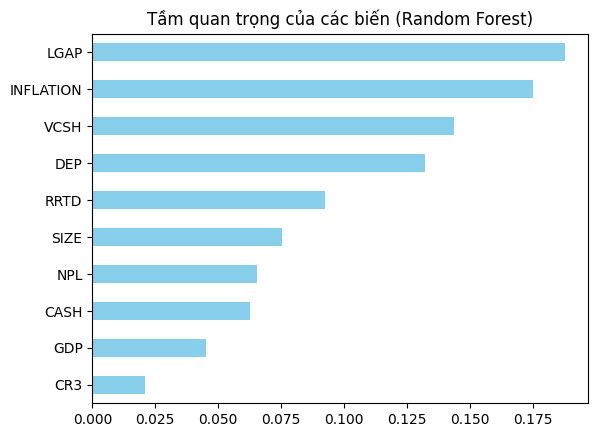

In [20]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 1. Huấn luyện RF
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(df[bien_doc_lap], df['ROA'])

# 2. Vẽ biểu đồ Feature Importance
importances = pd.Series(rf.feature_importances_, index=bien_doc_lap).sort_values()
importances.plot(kind='barh', color='skyblue')
plt.title("Tầm quan trọng của các biến (Random Forest)")
plt.show()

In [21]:
# 1. Lấy dự báo từ GLS đã chạy
df['pred_gls'] = results.predict(df)

# 2. Tính sai số (Residuals)
df['residuals'] = df['ROA'] - df['pred_gls']

# 3. Dùng Random Forest học trên sai số
from sklearn.ensemble import RandomForestRegressor
rf_res = RandomForestRegressor(n_estimators=100, random_state=42)
rf_res.fit(df[bien_doc_lap], df['residuals'])

# 4. Dự báo Hybrid
pred_residual = rf_res.predict(df[bien_doc_lap])
df['pred_hybrid'] = df['pred_gls'] + pred_residual

# 5. Kiểm tra R-squared mới
from sklearn.metrics import r2_score
print(f"R-squared Hybrid: {r2_score(df['ROA'], df['pred_hybrid']):.4f}")

R-squared Hybrid: 0.8973



=== KẾT QUẢ SO SÁNH HIỆU QUẢ DỰ BÁO ===
--- Mô hình GLS Gốc ---
RMSE (Sai số chuẩn): 0.00687
MAE (Sai số tuyệt đối): 0.00439
R-squared (Độ giải thích): 0.3208 (32.08%)
------------------------------
--- Mô hình Hybrid (GLS + RF) ---
RMSE (Sai số chuẩn): 0.00300
MAE (Sai số tuyệt đối): 0.00192
R-squared (Độ giải thích): 0.8704 (87.04%)
------------------------------


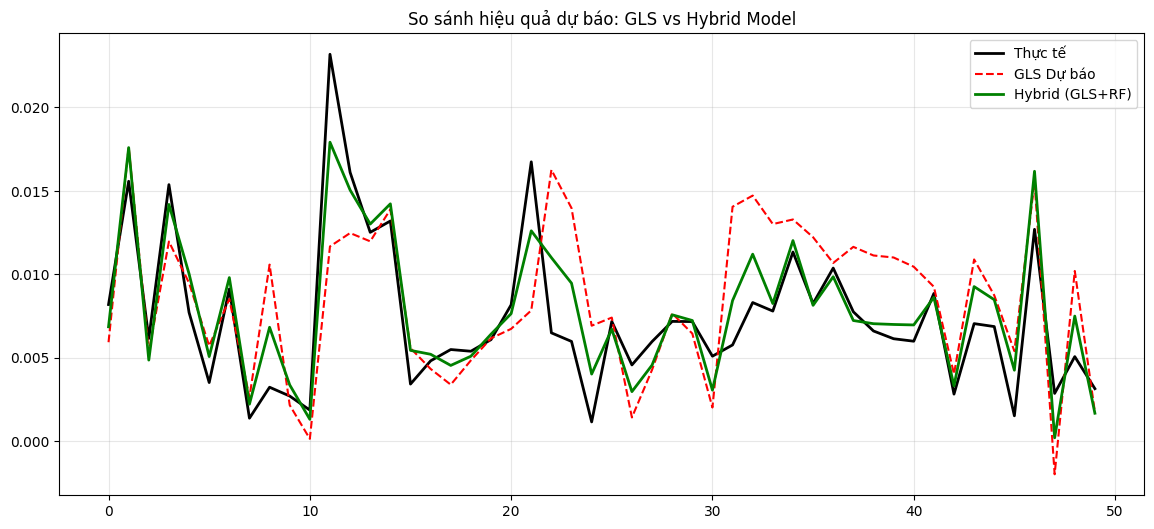

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================================
# PHẦN 1: CHUẨN BỊ DỮ LIỆU
# ==========================================================

# 1. Danh sách các biến độc lập (phải khớp với mô hình GLS bạn đã chạy)
features = ['DEP', 'CASH', 'LGAP', 'NPL', 'SIZE', 'CR3', 'VCSH', 'RRTD', 'GDP', 'INFLATION']

# 2. Lấy dự báo từ mô hình GLS (GEE) đã chạy ở bước trước
# (Biến 'results' là kết quả từ lệnh model.fit(cov_type='naive') của bạn)
df['GLS_Pred'] = results.predict(df)

# 3. Tính sai số (Residuals) mà GLS chưa giải thích được
df['GLS_Residuals'] = df['ROA'] - df['GLS_Pred']

# ==========================================================
# PHẦN 2: CHẠY RANDOM FOREST TRÊN SAI SỐ (RESIDUAL LEARNING)
# ==========================================================

# Khởi tạo mô hình Random Forest
# n_estimators=100: Số lượng cây
# random_state=42: Để kết quả cố định mỗi lần chạy
rf_residual_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)

# Huấn luyện RF: Đầu vào là X, Mục tiêu là SAI SỐ (không phải ROA)
rf_residual_model.fit(df[features], df['GLS_Residuals'])

# Dự báo phần sai số bù trừ
df['RF_Residual_Pred'] = rf_residual_model.predict(df[features])

# ==========================================================
# PHẦN 3: TỔNG HỢP KẾT QUẢ (HYBRID MODEL)
# ==========================================================

# Công thức: Kết quả cuối = Phần tuyến tính (GLS) + Phần phi tuyến (RF)
df['Hybrid_Pred'] = df['GLS_Pred'] + df['RF_Residual_Pred']

# ==========================================================
# PHẦN 4: SO SÁNH HIỆU QUẢ
# ==========================================================

def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} ---")
    print(f"RMSE (Sai số chuẩn): {rmse:.5f}")
    print(f"MAE (Sai số tuyệt đối): {mae:.5f}")
    print(f"R-squared (Độ giải thích): {r2:.4f} ({r2*100:.2f}%)")
    print("-" * 30)

print("\n=== KẾT QUẢ SO SÁNH HIỆU QUẢ DỰ BÁO ===")
calculate_metrics(df['ROA'], df['GLS_Pred'], "Mô hình GLS Gốc")
calculate_metrics(df['ROA'], df['Hybrid_Pred'], "Mô hình Hybrid (GLS + RF)")

# ==========================================================
# PHẦN 5: VẼ BIỂU ĐỒ TRỰC QUAN HÓA
# ==========================================================

# Vẽ 50 quan sát đầu tiên để dễ nhìn
plt.figure(figsize=(14, 6))
plt.plot(df['ROA'].values[:50], label='Thực tế', color='black', linewidth=2)
plt.plot(df['GLS_Pred'].values[:50], label='GLS Dự báo', color='red', linestyle='--')
plt.plot(df['Hybrid_Pred'].values[:50], label='Hybrid (GLS+RF)', color='green', linewidth=2)

plt.title('So sánh hiệu quả dự báo: GLS vs Hybrid Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()